In [3]:
import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

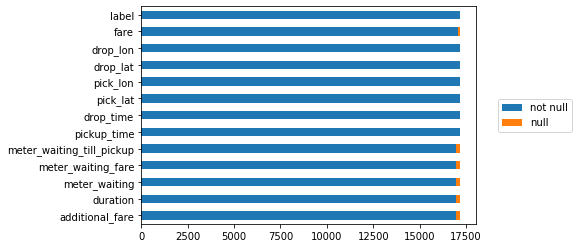

In [5]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

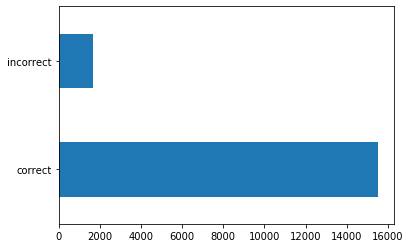

In [6]:
train_df['label'].value_counts().plot.barh()

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

RANDOM_SEED = 42  

In [31]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [32]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [33]:
labels_df = preprocess_labels(labels_raw_df)

In [37]:
def preprocess_features(input_features_df):
  features_df = input_features_df.copy()
  numeric_cols = features_df.columns[features_df.dtypes != "object"].values 
  non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values

  #numeric
  #scale features
  scaler = RobustScaler()
  features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

  #impute missing values
  imputer = SimpleImputer('median')
  features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])

  #date time
  features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
  features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
  
  #get day of the week
  features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
  features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
  
  features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
  features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

  #encode cyclic 24 hours with sin and cos
  features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
  features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

  features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
  features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)

  #get weekday or weekend
  weekenddays = ['Saturday', 'Sunday']

  features_df['pickup_weekday'] = np.where(features_df['pickup_day_of_week'].isin(weekenddays), 0, 1)
  features_df['drop_weekday'] = np.where(features_df['drop_day_of_week'].isin(weekenddays), 0, 1)
  
  features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
  
  features_df = features_df.drop(columns=['pickup_time','drop_time'])
  
  return features_df

In [38]:
features_df = preprocess_features(features_raw_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [28]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

NameError: name 'SimpleImputer' is not defined

In [29]:
def predict_test_set(model, test_features_df, submission_no):
    global thresh
    
    test_pred = model.predict(xgb.DMatrix(test_features_df))
    
    test_pred [test_pred > thresh] = 1
    test_pred [test_pred <= thresh] = 0
    
    submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")
    
    # Make sure we have the rows in the same order
    np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)
    
    # Save predictions to submission data frame
    submission_df["prediction"] = test_pred
    
    submission_df['prediction'] = submission_df['prediction'].astype(int)

    submission_df.to_csv(f'../submission{submission_no}.csv', index=True)

In [15]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

RANDOM_SEED = 5 

In [16]:
x_train, x_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
]

grid_search_forest = GridSearchCV(rf, param_grid, cv=10, scoring='f1_macro', n_jobs = -1)
grid_search_forest.fit(x_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [20]:
#find the best model of grid search
grid_search_forest.best_params_

{'bootstrap': False, 'max_depth': None, 'max_features': 10, 'n_estimators': 10}

In [22]:
grid_best= grid_search_forest.best_estimator_.predict(x_eval)

In [23]:
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best)))
print('F1 score: {:.6f}'.format(f1_score(y_eval, grid_best, average='macro')))

F1 score: 0.962846
F1 score: 0.766615
